# **Agents Estimation and AQI prediction**

After finding the best model for each agent, use them to compute the overall pollution estimations and AQI values.

## **Notebook Setup**

In [8]:
%load_ext autoreload
%autoreload 2

from datetime import datetime

from utils import *

datasets_folder = './datasets'
verbosity = 0
figsize = (18,4)

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[]


In [9]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [10]:
station_data = {}
station_dists = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station], station_dists[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 33


In [11]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'

In [12]:
train_sets = {}
test_sets = {}

for station in stations:
    train_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        train_sets[station][agent] = {}
        test_sets[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent], train_split_date, y=target)

        train_sets[station][agent]['x'] = x_train
        train_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = x_test
        test_sets[station][agent]['y'] = y_test

## **Agents Estimations**

Prepare a dictionary containing all the models to use for each agent of each station.

TODO check if the model changed after new execution with standardized values

### **Hourly models**

#### XGBoost

In [13]:
xgbr_params = {
    'objective': "reg:absoluteerror",
    'n_estimators': 180,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9
}

xgbr = ('XGB Regressor', xgb.XGBRegressor, xgbr_params, None, False)

#### LSTM

In [14]:
lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error',
    'use_mask': True
}

lstm_train_params = {
    'epochs': 20,
    'batch_size': 64
}

lstm = ('LSTM-masked', build_lstm_model, lstm_params, lstm_train_params, True)

In [15]:
lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': True
}

lstm2_train_params = {
    'epochs': 20,
    'batch_size': 32
}

lstm2 = ('LSTM_2-masked', build_lstm_model, lstm2_params, lstm2_train_params, True)

#### FFNN

In [16]:
ffnn_params = {
    'input_size': n_hour_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn_train_params = {
    'epochs': 10,
    'batch_size': 32
}

FFNN = ('Feed Forward NN', build_ffnn_model, ffnn_params, ffnn_train_params, False)

In [17]:
bn_ffnn2_params = {
    'input_size': n_hour_features,
    'neurons': [512, 256, 128],
    'batch_norm': True,
    'dropout': 0.3,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

bn_ffnn2_train_params = {
    'epochs':10,
    'batch_size':32,
}

FFNN2_BN = ('Feed Forward NN 2', build_ffnn_model, bn_ffnn2_params, bn_ffnn2_train_params, False)

#### 1D Convolution

In [18]:
conv_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': 64,
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv_train_params = {
    'epochs': 10,
    'batch_size': 64
}

conv = ('Conv1D', build_conv_model, conv_params, conv_train_params, True)

In [19]:
conv2_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv2_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

conv2 = ('Conv1D 2', build_conv_model, conv2_params, conv2_train_params, True)

In [20]:
conv3_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv3_train_params = {
    'epochs': 20,
    'batch_size': 32,
}

conv3 = ('Conv1D 3', build_conv_model, conv3_params, conv3_train_params, True)

### **Daily Models**

#### FFNN

In [21]:
ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32
}

FFNN_daily = ('Feed Forward NN', build_ffnn_model, ffnn_daily_params, ffnn_daily_train_params, False)

In [22]:
bn_ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'batch_norm': True,
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

bn_ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

FFNN_daily_BN = ('Feed Forward NN BatchNorm', build_ffnn_model, bn_ffnn_daily_params, bn_ffnn_daily_train_params, False)

In [23]:
rfr2_params = {
    'n_estimators':150,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2'
}

rfr2 = ('Random Forest Regressor 2', RandomForestRegressor, rfr2_params, None, False)

### **Training**

In [24]:
models = {
    'GIARDINI MARGHERITA':{
        'NO2': conv2, 
        'O3': conv3,
        'PM10': rfr2,
        'PM2.5': FFNN_daily 
    },
    'PORTA SAN FELICE':{
        'C6H6': conv, 
        'CO': xgbr, 
        'NO2': lstm,
        'PM10':FFNN_daily_BN,  
        'PM2.5':FFNN_daily_BN 
    },
    'VIA CHIARINI':{
        'NO2': FFNN2_BN, 
        'O3': conv2, 
        'PM10':rfr2  
    }
}

In [25]:
agents_predictions = train_agents(models, train_sets, test_sets, model_out_folder='./models')

Predicting NO2 in GIARDINI MARGHERITA using Conv1D 2...


INFO:tensorflow:Assets written to: ./models\GIARDINI_MARGHERITA.NO2\assets


INFO:tensorflow:Assets written to: ./models\GIARDINI_MARGHERITA.NO2\assets


Predicting O3 in GIARDINI MARGHERITA using Conv1D 3...


INFO:tensorflow:Assets written to: ./models\GIARDINI_MARGHERITA.O3\assets


INFO:tensorflow:Assets written to: ./models\GIARDINI_MARGHERITA.O3\assets


Predicting PM10 in GIARDINI MARGHERITA using Random Forest Regressor 2...
Predicting PM2.5 in GIARDINI MARGHERITA using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models\GIARDINI_MARGHERITA.PM2_5\assets


INFO:tensorflow:Assets written to: ./models\GIARDINI_MARGHERITA.PM2_5\assets


Predicting C6H6 in PORTA SAN FELICE using Conv1D...


INFO:tensorflow:Assets written to: ./models\PORTA_SAN_FELICE.C6H6\assets


INFO:tensorflow:Assets written to: ./models\PORTA_SAN_FELICE.C6H6\assets


Predicting CO in PORTA SAN FELICE using XGB Regressor...
Predicting NO2 in PORTA SAN FELICE using LSTM-masked...


INFO:tensorflow:Assets written to: ./models\PORTA_SAN_FELICE.NO2\assets


INFO:tensorflow:Assets written to: ./models\PORTA_SAN_FELICE.NO2\assets


Predicting PM10 in PORTA SAN FELICE using Feed Forward NN BatchNorm...
INFO:tensorflow:Assets written to: ./models\PORTA_SAN_FELICE.PM10\assets


INFO:tensorflow:Assets written to: ./models\PORTA_SAN_FELICE.PM10\assets


Predicting PM2.5 in PORTA SAN FELICE using Feed Forward NN BatchNorm...
INFO:tensorflow:Assets written to: ./models\PORTA_SAN_FELICE.PM2_5\assets


INFO:tensorflow:Assets written to: ./models\PORTA_SAN_FELICE.PM2_5\assets


Predicting NO2 in VIA CHIARINI using Feed Forward NN 2...
INFO:tensorflow:Assets written to: ./models\VIA_CHIARINI.NO2\assets


INFO:tensorflow:Assets written to: ./models\VIA_CHIARINI.NO2\assets


Predicting O3 in VIA CHIARINI using Conv1D 2...


INFO:tensorflow:Assets written to: ./models\VIA_CHIARINI.O3\assets


INFO:tensorflow:Assets written to: ./models\VIA_CHIARINI.O3\assets


Predicting PM10 in VIA CHIARINI using Random Forest Regressor 2...


In [26]:
metrics_predictions = training_results_to_dataframe(agents_predictions, multiple_models=False)
metrics_predictions

,Station,Agent,root_mean_squared_error,r2_score,mean_absolute_error,huber
0,GIARDINI MARGHERITA,NO2,0.513593,0.625363,0.347737,0.052809
1,GIARDINI MARGHERITA,O3,0.332400,0.875833,0.246584,0.033535
2,GIARDINI MARGHERITA,PM10,0.727544,0.414355,0.509978,0.084247
3,GIARDINI MARGHERITA,PM2.5,0.707275,0.504059,0.474451,0.077263
4,PORTA SAN FELICE,C6H6,0.606835,0.601584,0.372489,0.057848
5,PORTA SAN FELICE,CO,0.664943,0.577658,0.510561,0.083937
6,PORTA SAN FELICE,NO2,0.982414,-0.789194,0.822815,0.145458
7,PORTA SAN FELICE,PM10,0.721080,0.485809,0.492130,0.080572
8,PORTA SAN FELICE,PM2.5,0.648971,0.591875,0.450173,0.072136
9,VIA CHIARINI,NO2,0.611395,0.393852,0.462198,0.074480


## **AQI calculation**

The steps to compute the Air Quality Index are the same illustrated in the [pollution notebook](./1-pollution_preprocessing.ipynb):


- we go back to the original distribution,

In [ ]:
agents_predictions_original_dist = agents_predictions.copy()
test_sets_original_dist = test_sets.copy()

In [ ]:
for station in stations:
    for agent in agents_predictions_original_dist[station]:
        test_sets_original_dist[station][agent]['y'] = (test_sets_original_dist[station][agent]['y'] * station_dists[station][agent]['std']) + station_dists[station][agent]['mean']
        agents_predictions_original_dist[station][agent]['predictions'] = (agents_predictions_original_dist[station][agent]['predictions'] * station_dists[station][agent]['std']) + station_dists[station][agent]['mean']


- then we compute the AQI of each agent,
- and then we take the maximums for each time step

In [ ]:
pred_AQIs_daily = {
    s: {agent: get_AQI(agents_predictions_original_dist[s][agent]['predictions'], 
                        agent=agent, 
                        period='day', 
                        value_column='Agent_value',
                        ) for agent in agents_predictions_original_dist[s].keys()} for s in agents_predictions_original_dist
}

pred_AQI_daily = merge_AQIs(pred_AQIs_daily, period='day')

pred_AQIs_hourly = {
    s: {agent: get_AQI(agents_predictions_original_dist[s][agent]['predictions'],
                       agent=agent,
                       period='hour', 
                       value_column='Agent_value',
                       include_hourly_pm=False
                       ) for agent in agents_predictions_original_dist[s].keys()} for s in agents_predictions_original_dist
}

pred_AQI_hourly = merge_AQIs(pred_AQIs_hourly, period='hour')

In [ ]:
true_AQIs_daily = {
    s: {agent: get_AQI(test_sets_original_dist[s][agent]['y'], 
                        agent=agent, 
                        period='day', 
                        value_column='Agent_value',
                        ) for agent in test_sets_original_dist[s].keys()} for s in test_sets_original_dist
}

true_AQI_daily = merge_AQIs(true_AQIs_daily, period='day')

true_AQIs_hourly = {
    s: {agent: get_AQI(test_sets_original_dist[s][agent]['y'],
                       agent=agent,
                       period='hour', 
                       value_column='Agent_value',
                       include_hourly_pm=False
                       ) for agent in test_sets_original_dist[s].keys()} for s in test_sets_original_dist
}

true_AQI_hourly = merge_AQIs(true_AQIs_hourly, period='hour')

- We also compute the difference between the true AQIs and the predicted values, for better comparison.

In [45]:
AQI_diff_daily = {}
AQI_diff_hourly = {}    

for station in true_AQI_hourly:
    AQI_diff_daily[station] = AQI_difference(pred_AQI_daily[station], true_AQI_daily[station])
    AQI_diff_hourly[station] = AQI_difference(pred_AQI_hourly[station], true_AQI_hourly[station])

## **AQI Comparison**

In [46]:
categories = {
    'Good': 0,
    'Moderate': 50,
    'Poor': 100,
    'Very Poor': 150,
    'Severe': 200,
}

### **Hourly AQI**

Station GIARDINI MARGHERITA AQI:


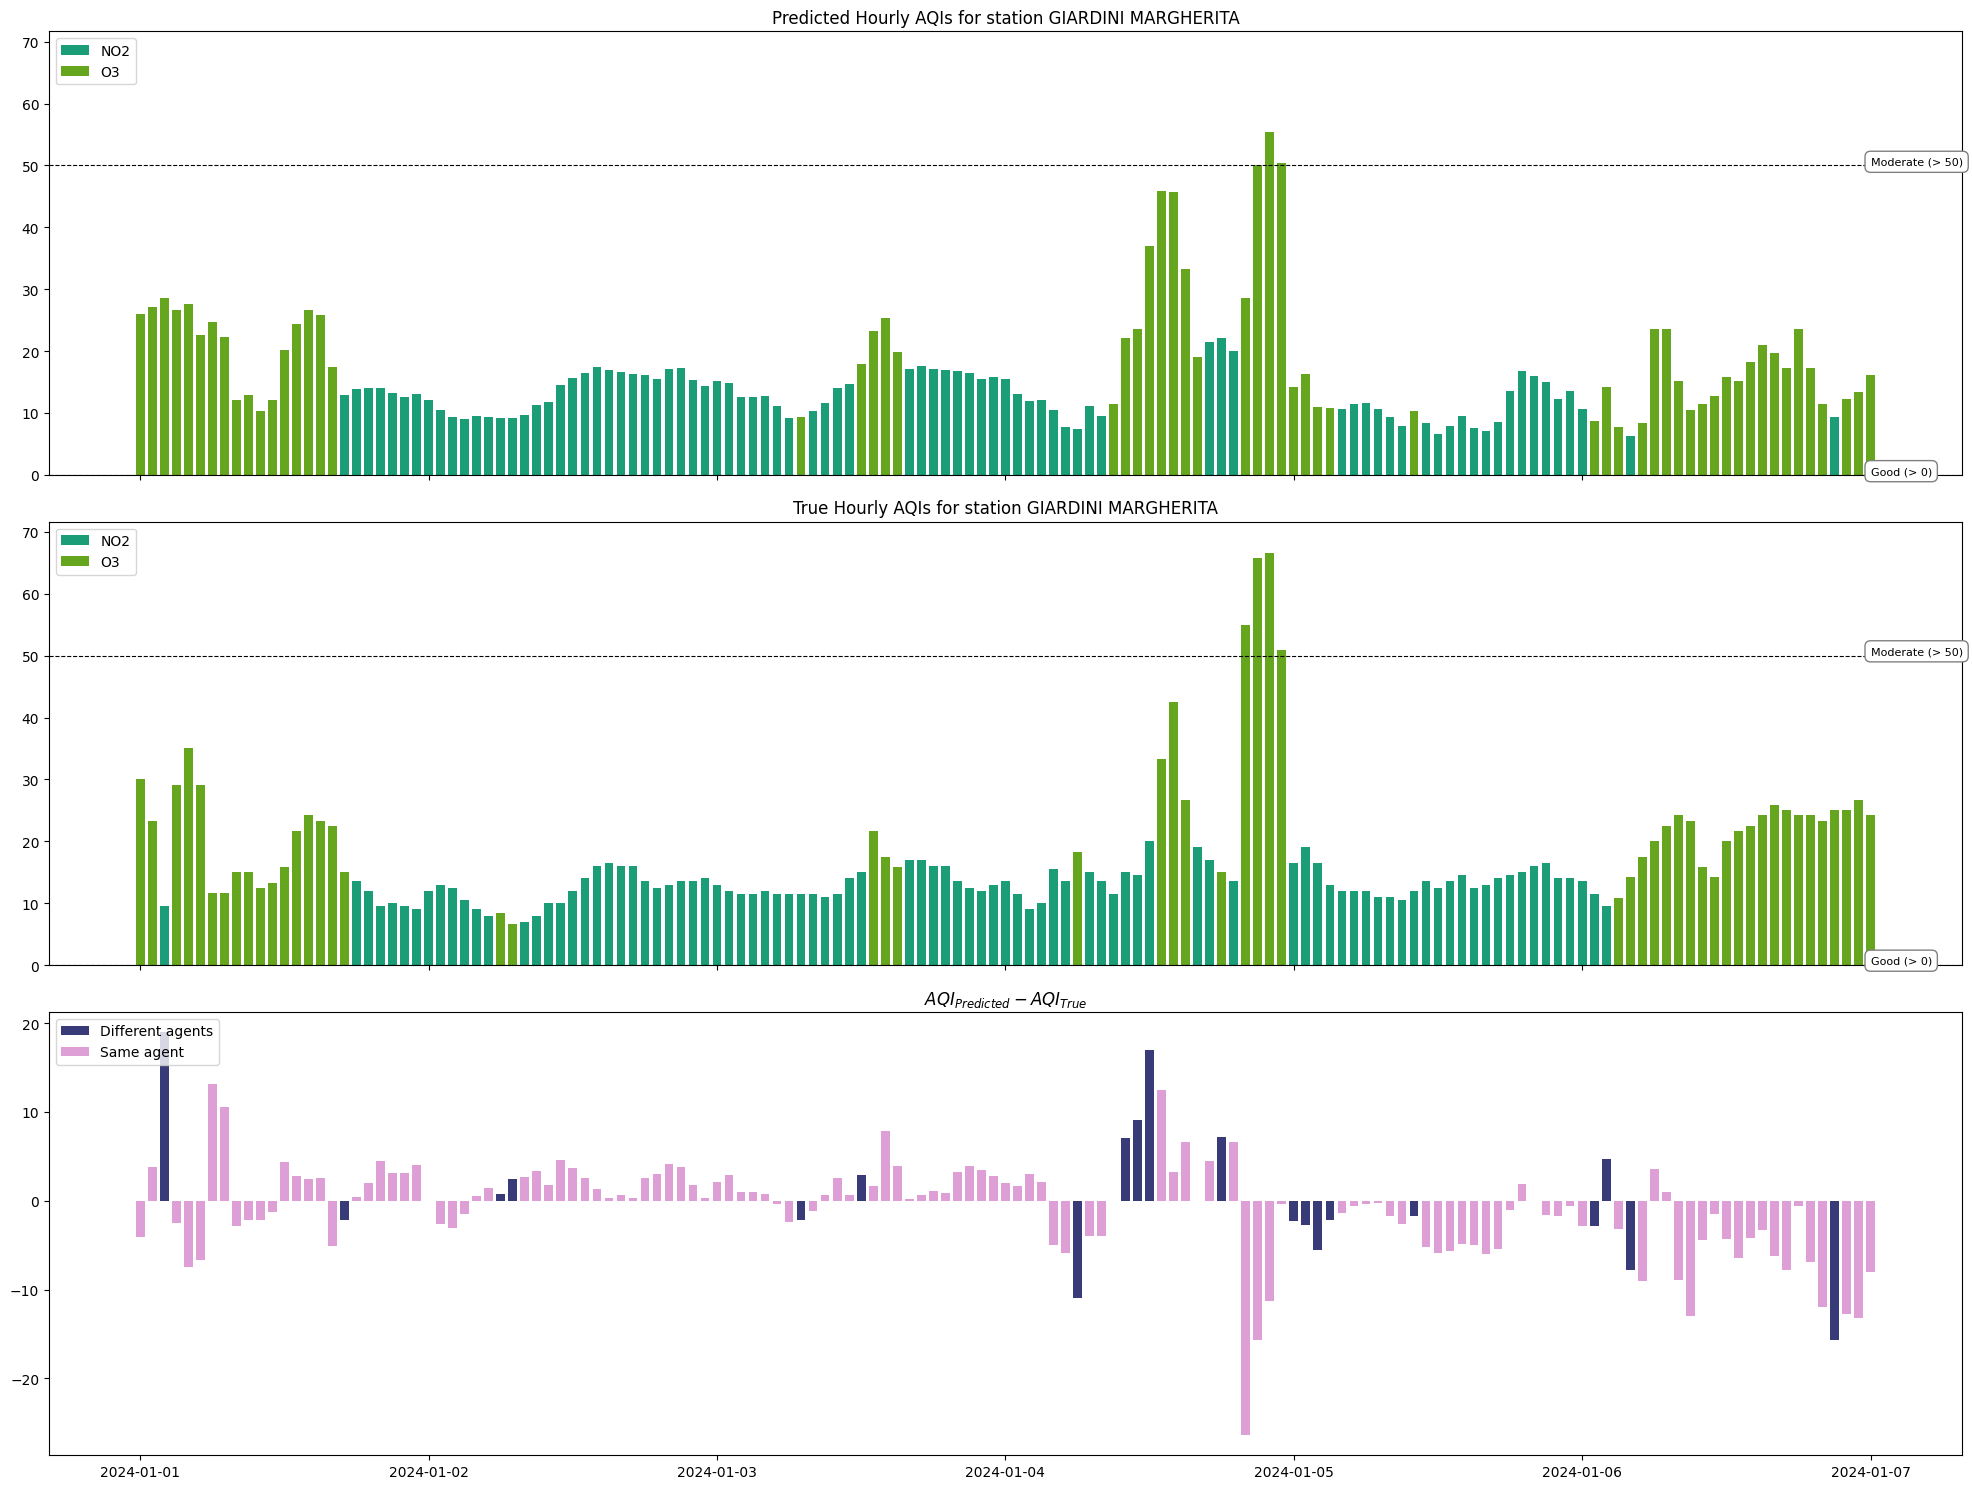

Station PORTA SAN FELICE AQI:


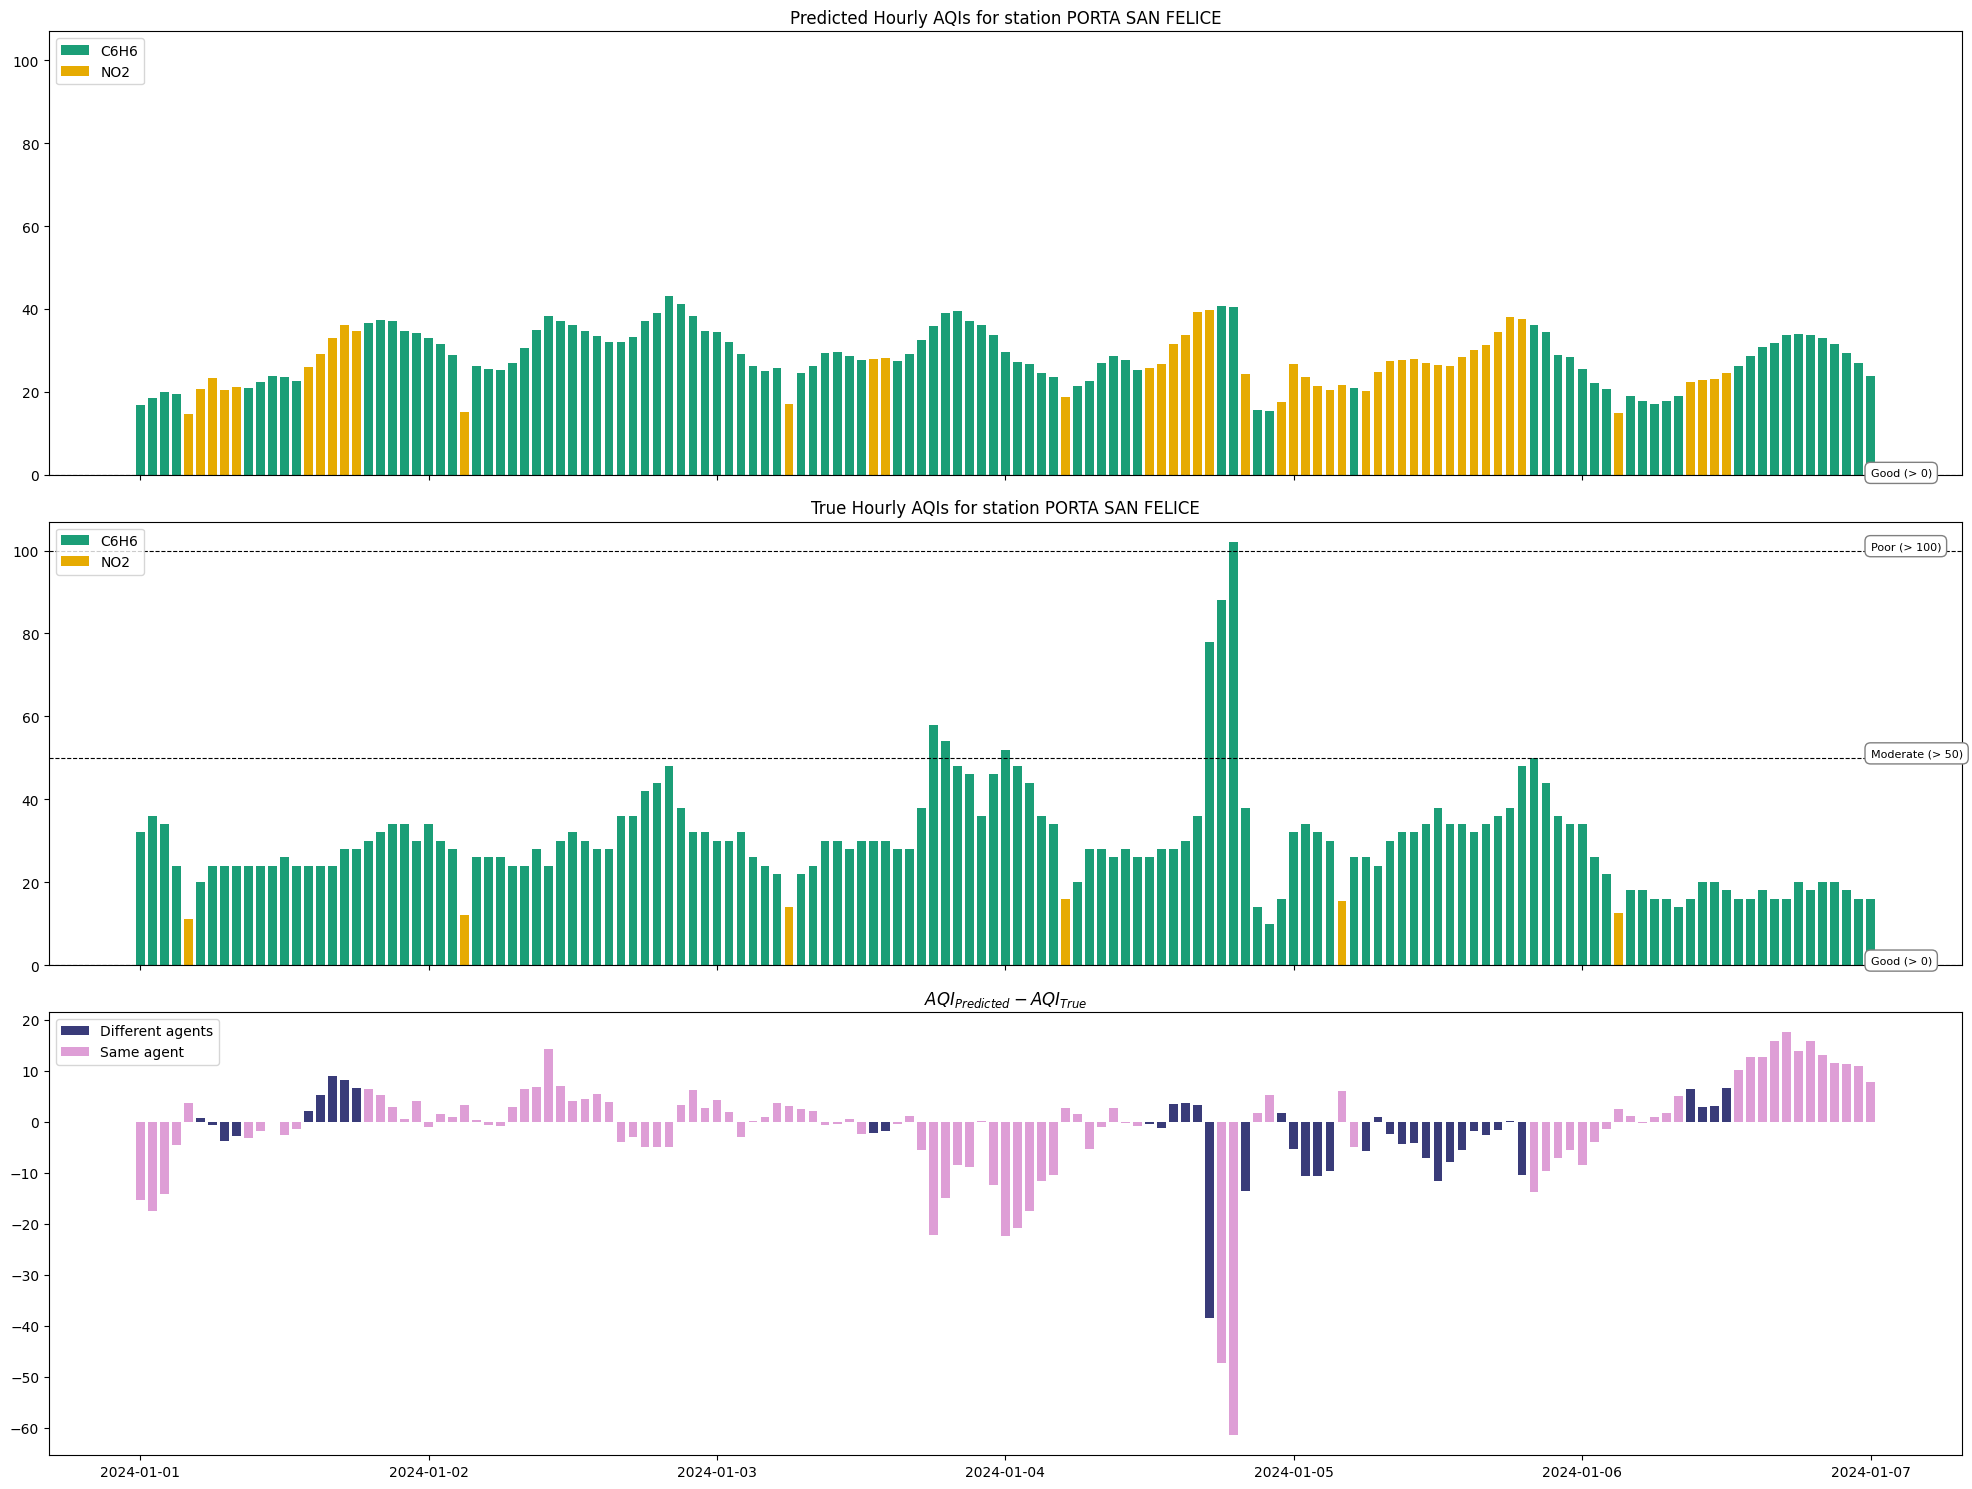

Station VIA CHIARINI AQI:


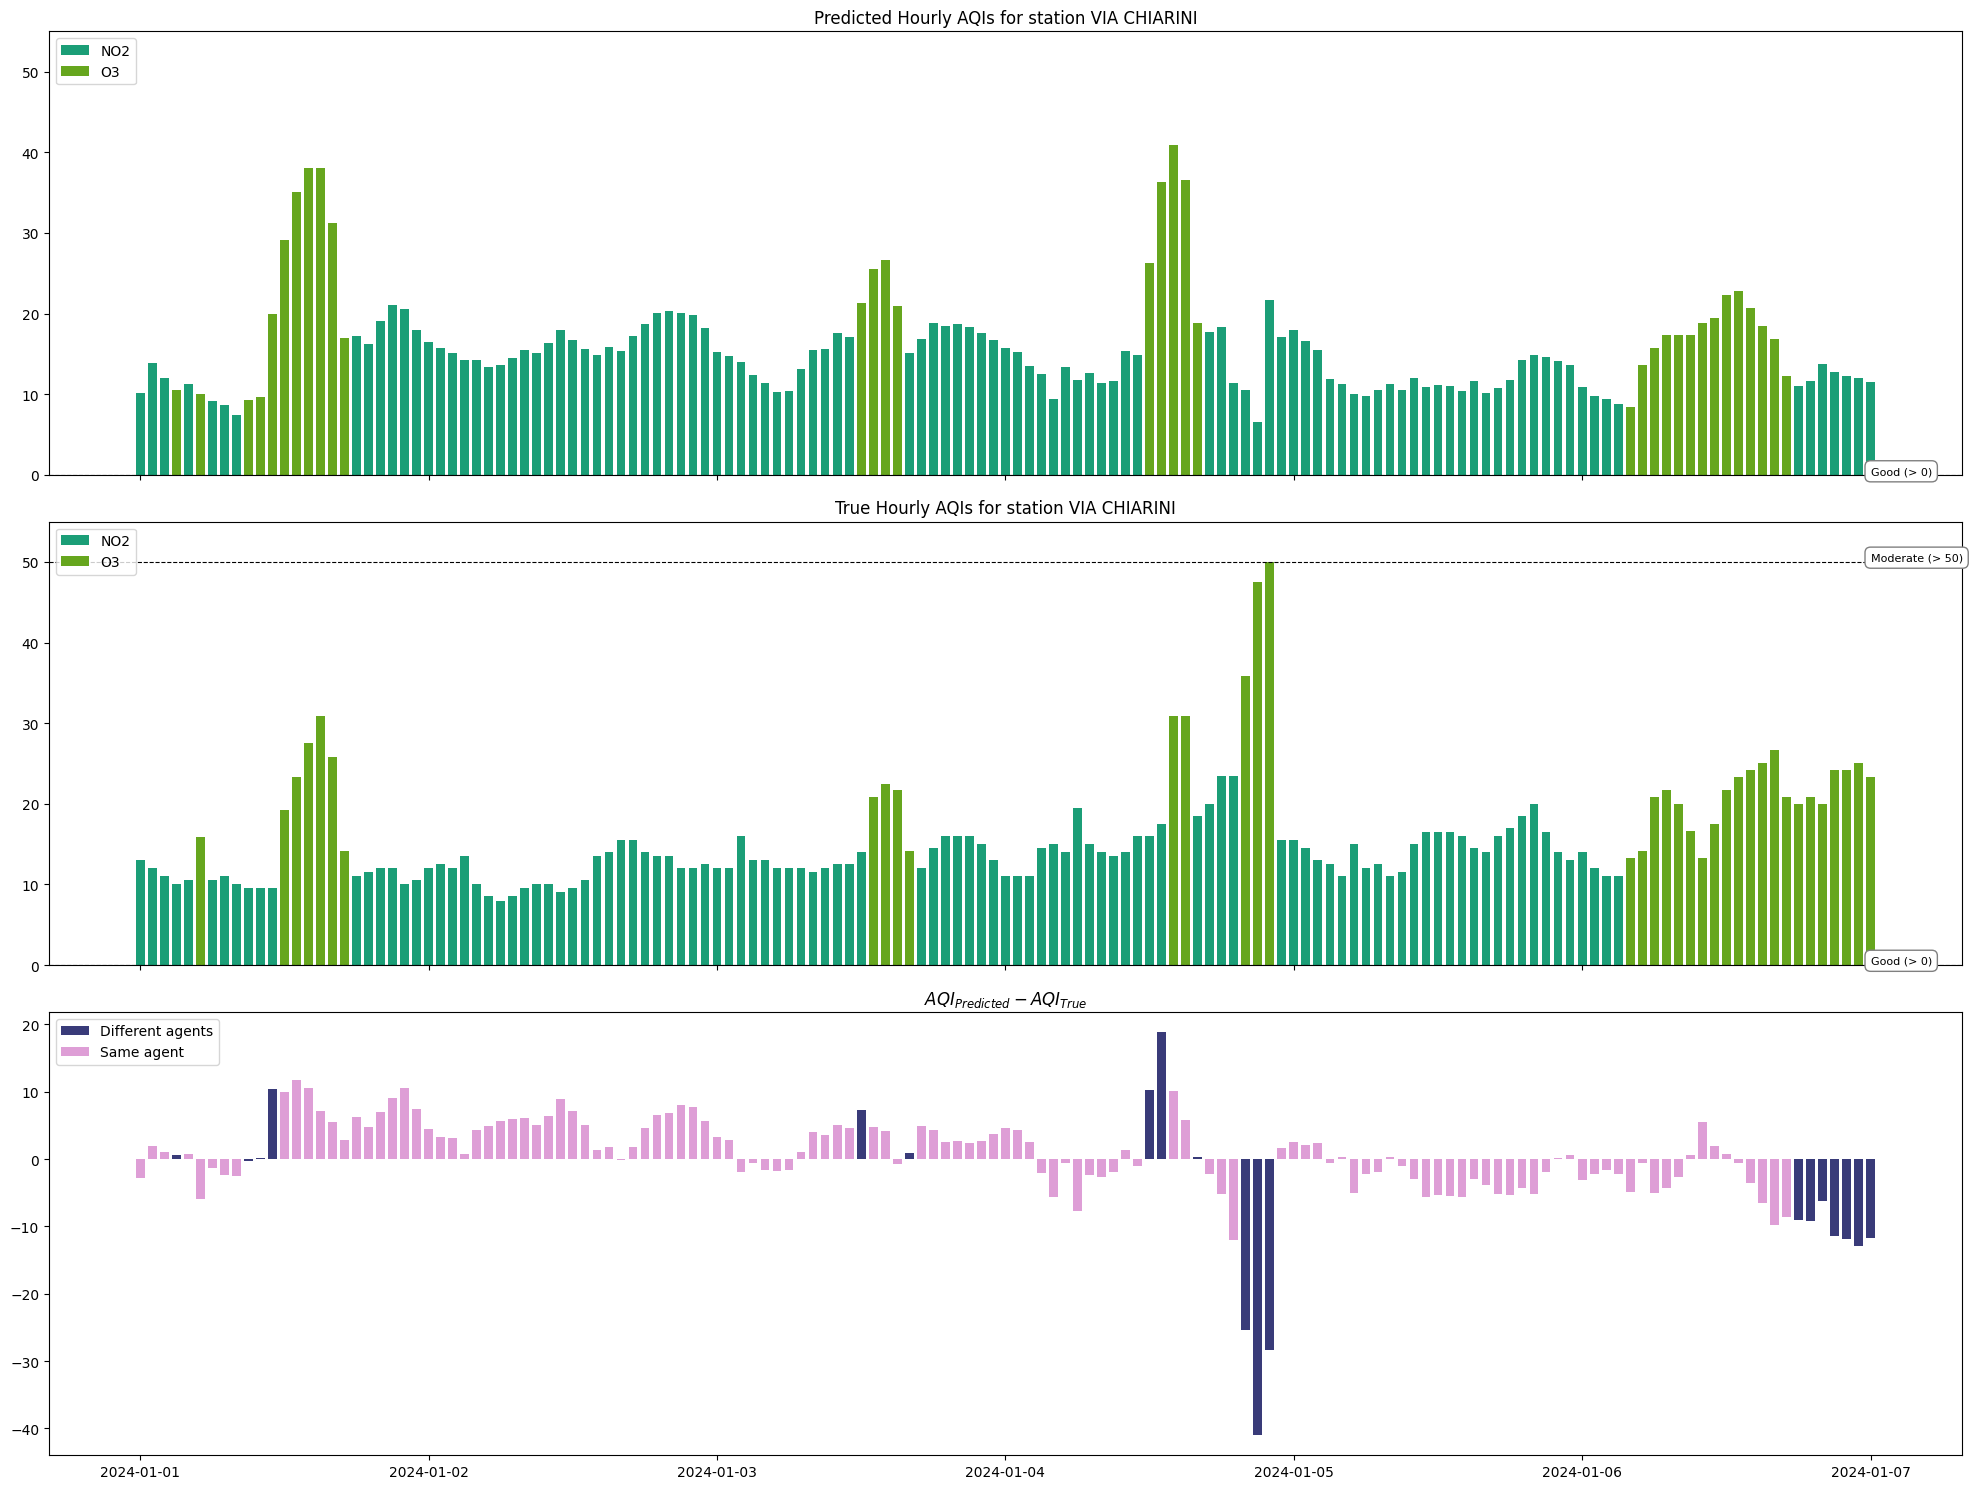

In [66]:
start=datetime(2024,1,1)
end=datetime(2024,1,7)

for station in true_AQIs_hourly:
    print(f'Station {station} AQI:')
    plot_AQI(
        station_AQI=[
            pred_AQI_hourly[station],
            true_AQI_hourly[station],
            AQI_diff_hourly[station]
        ], 
        title=[
            f'Predicted Hourly AQIs for station {station}',
            f'True Hourly AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ],
        categories=categories,
        figsize=(20, 5), s=start, e=end)

Station GIARDINI MARGHERITA


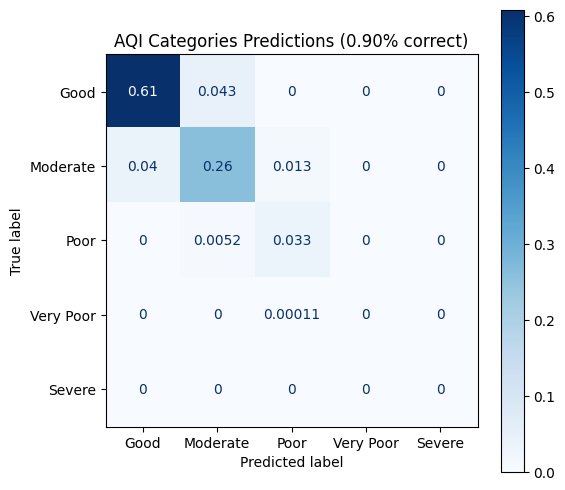

---------------------------------------------
> Absolute Mean AQI Difference: 7.44
> Positive Average AQI Difference: 7.48
> Negative Average AQI Difference: -7.40
> Percentage of Positive Differences: 51.74%
> Percentage of Negative Differences: 48.04%
> Percentage of Agent Values:
   - Same agent: 89.7
   - Different agents: 10.3
Station PORTA SAN FELICE


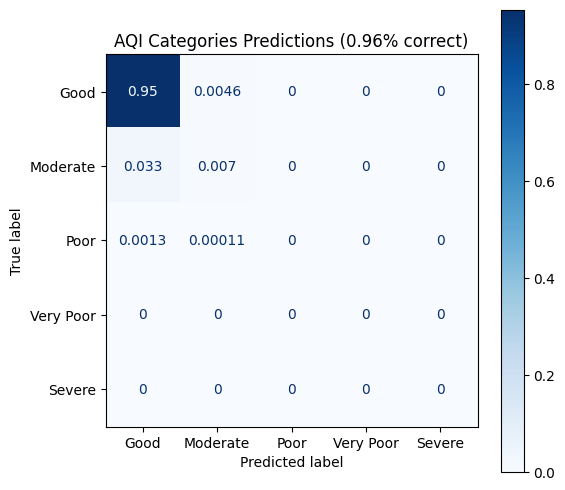

---------------------------------------------
> Absolute Mean AQI Difference: 6.61
> Positive Average AQI Difference: 6.04
> Negative Average AQI Difference: -7.45
> Percentage of Positive Differences: 59.48%
> Percentage of Negative Differences: 40.32%
> Percentage of Agent Values:
   - Same agent: 55.85
   - Different agents: 44.15
Station VIA CHIARINI


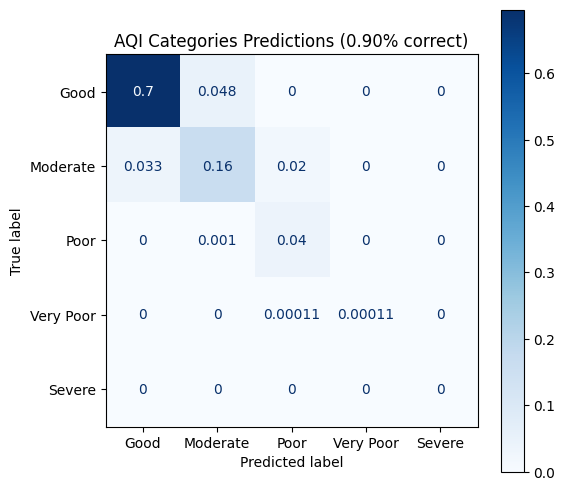

---------------------------------------------
> Absolute Mean AQI Difference: 8.06
> Positive Average AQI Difference: 8.63
> Negative Average AQI Difference: -6.89
> Percentage of Positive Differences: 67.19%
> Percentage of Negative Differences: 32.50%
> Percentage of Agent Values:
   - Same agent: 87.28
   - Different agents: 12.72


In [67]:
for station in stations:
    print('=============================================')
    print(f'Station {station}')
    print('=============================================')
    print_AQI_category_comparison(pred_AQI_hourly[station],true_AQI_hourly[station], categories=categories)
    print('---------------------------------------------')
    print_AQI_difference_metrics(AQI_diff_hourly[station])
    print('=============================================')

### **Daily AQI**

Station GIARDINI MARGHERITA AQI:


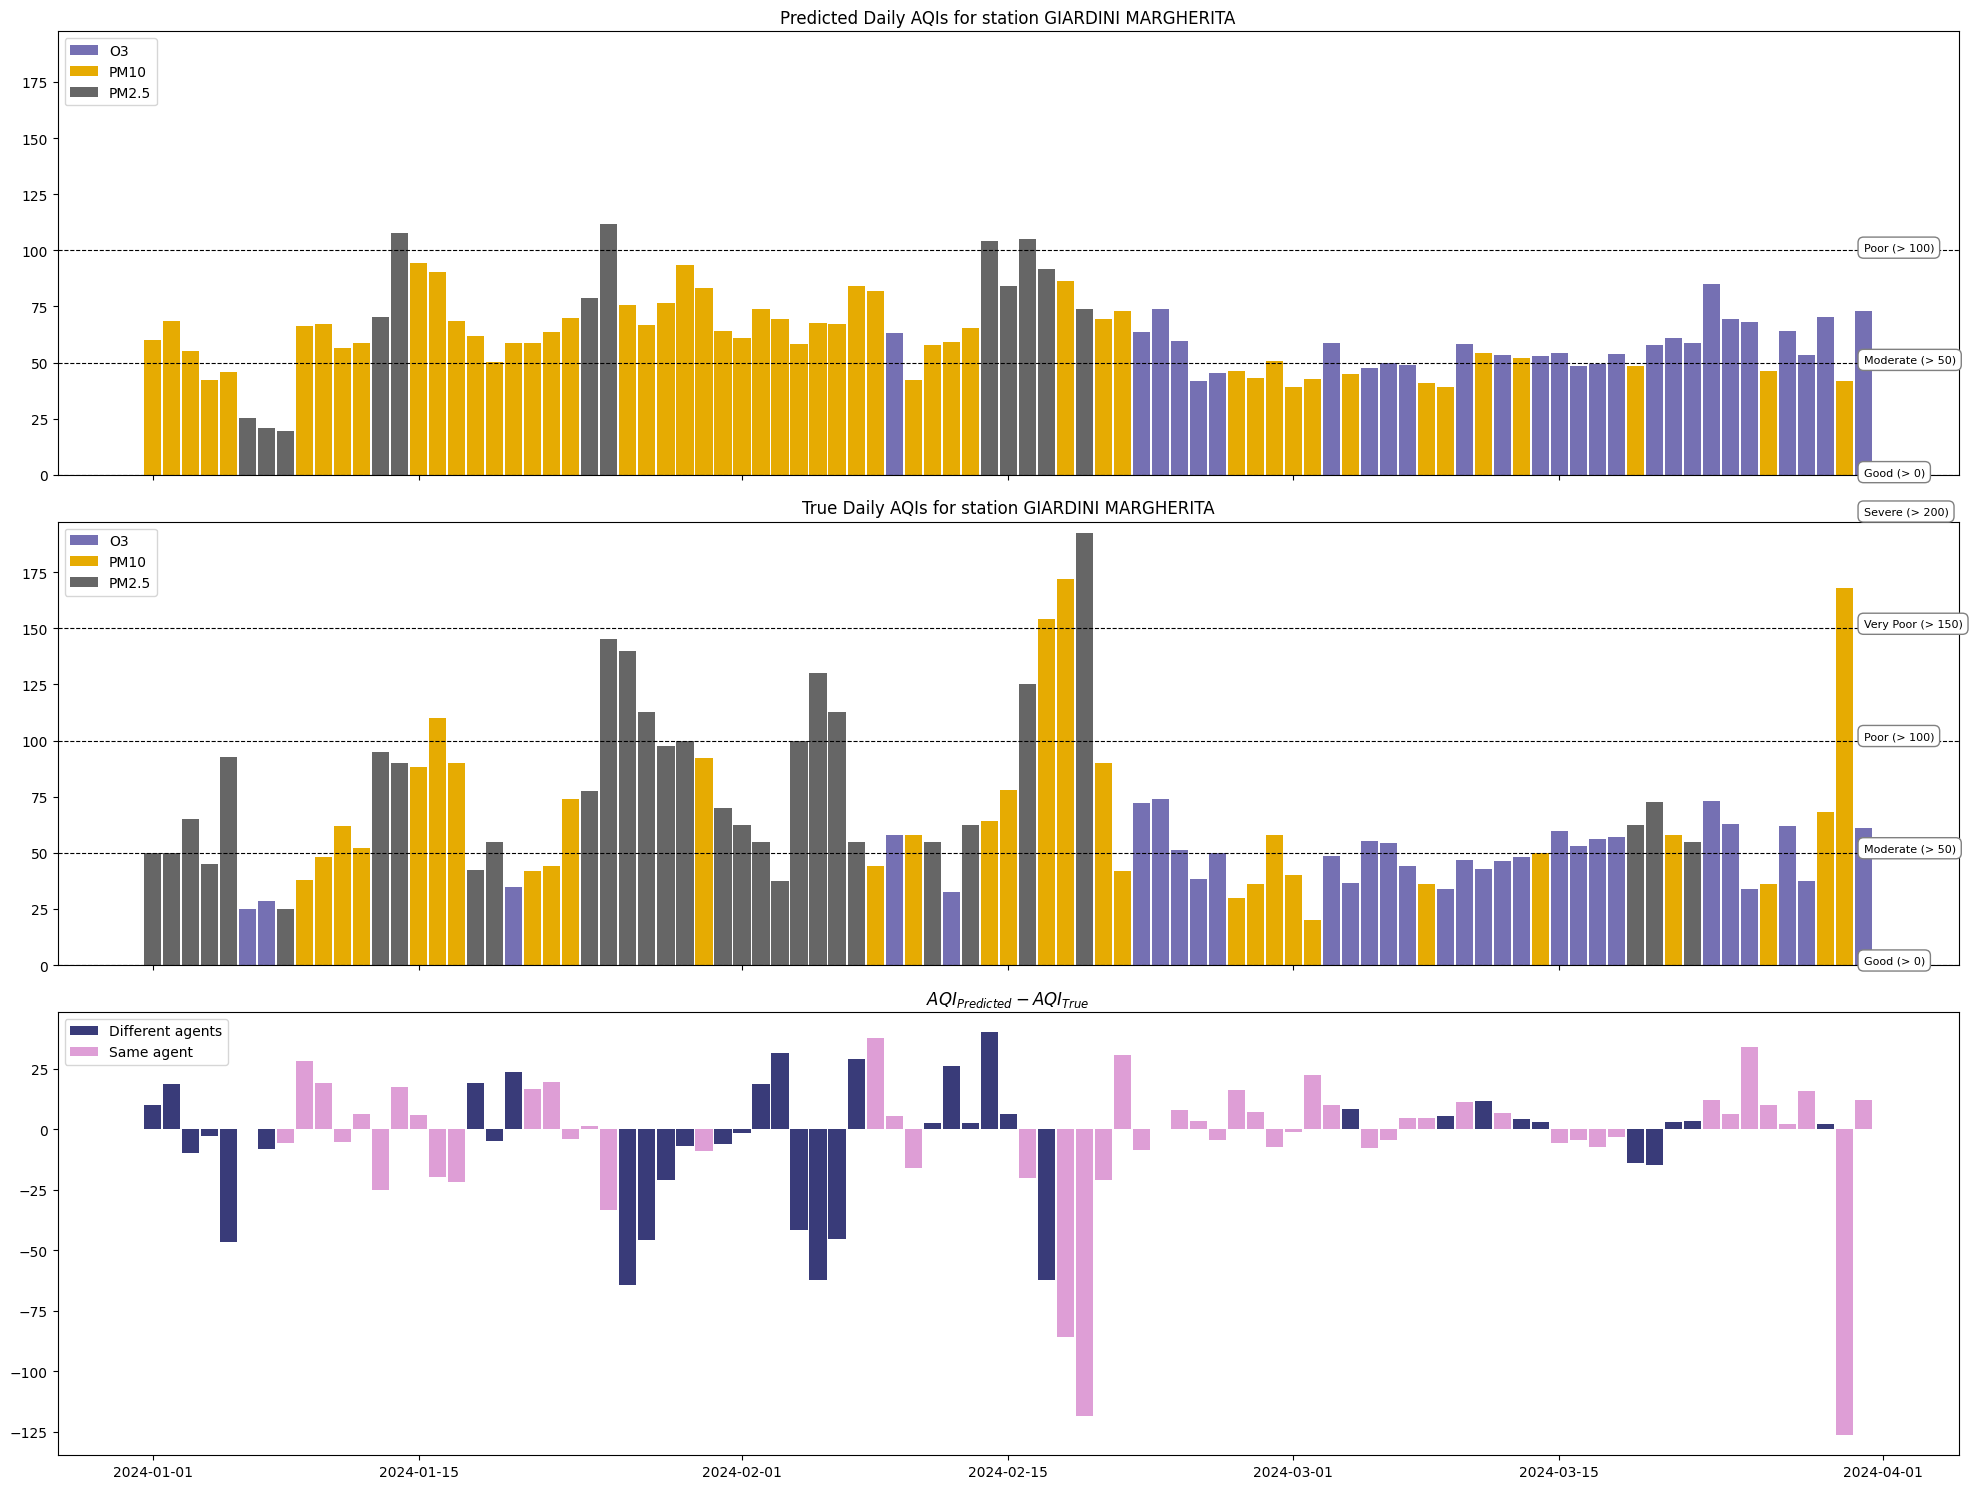

Station PORTA SAN FELICE AQI:


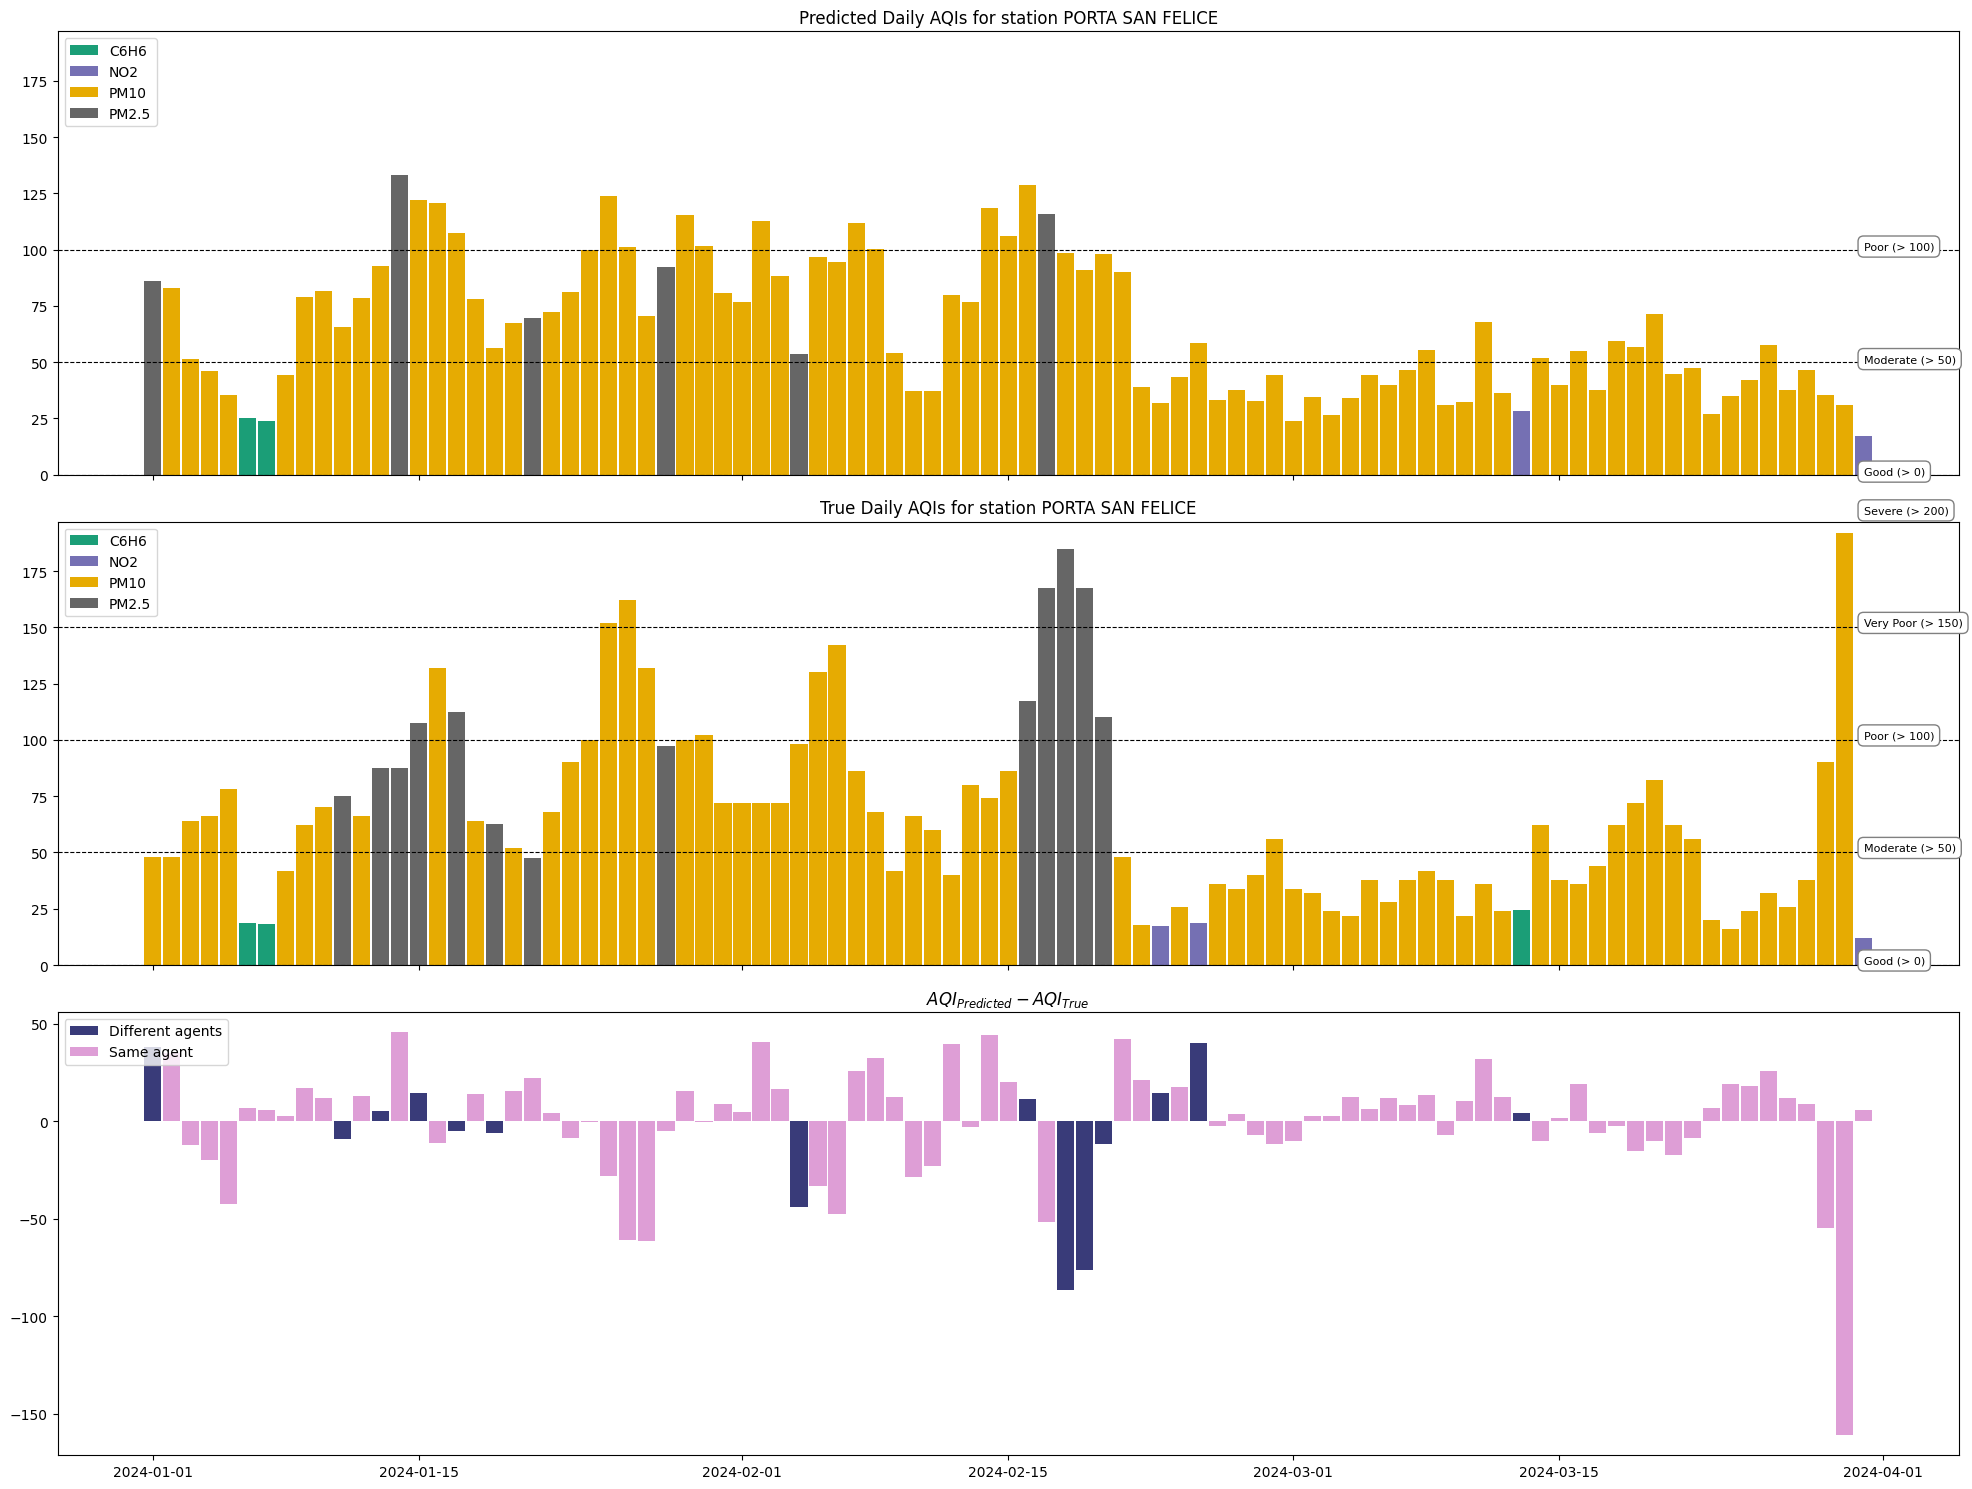

Station VIA CHIARINI AQI:


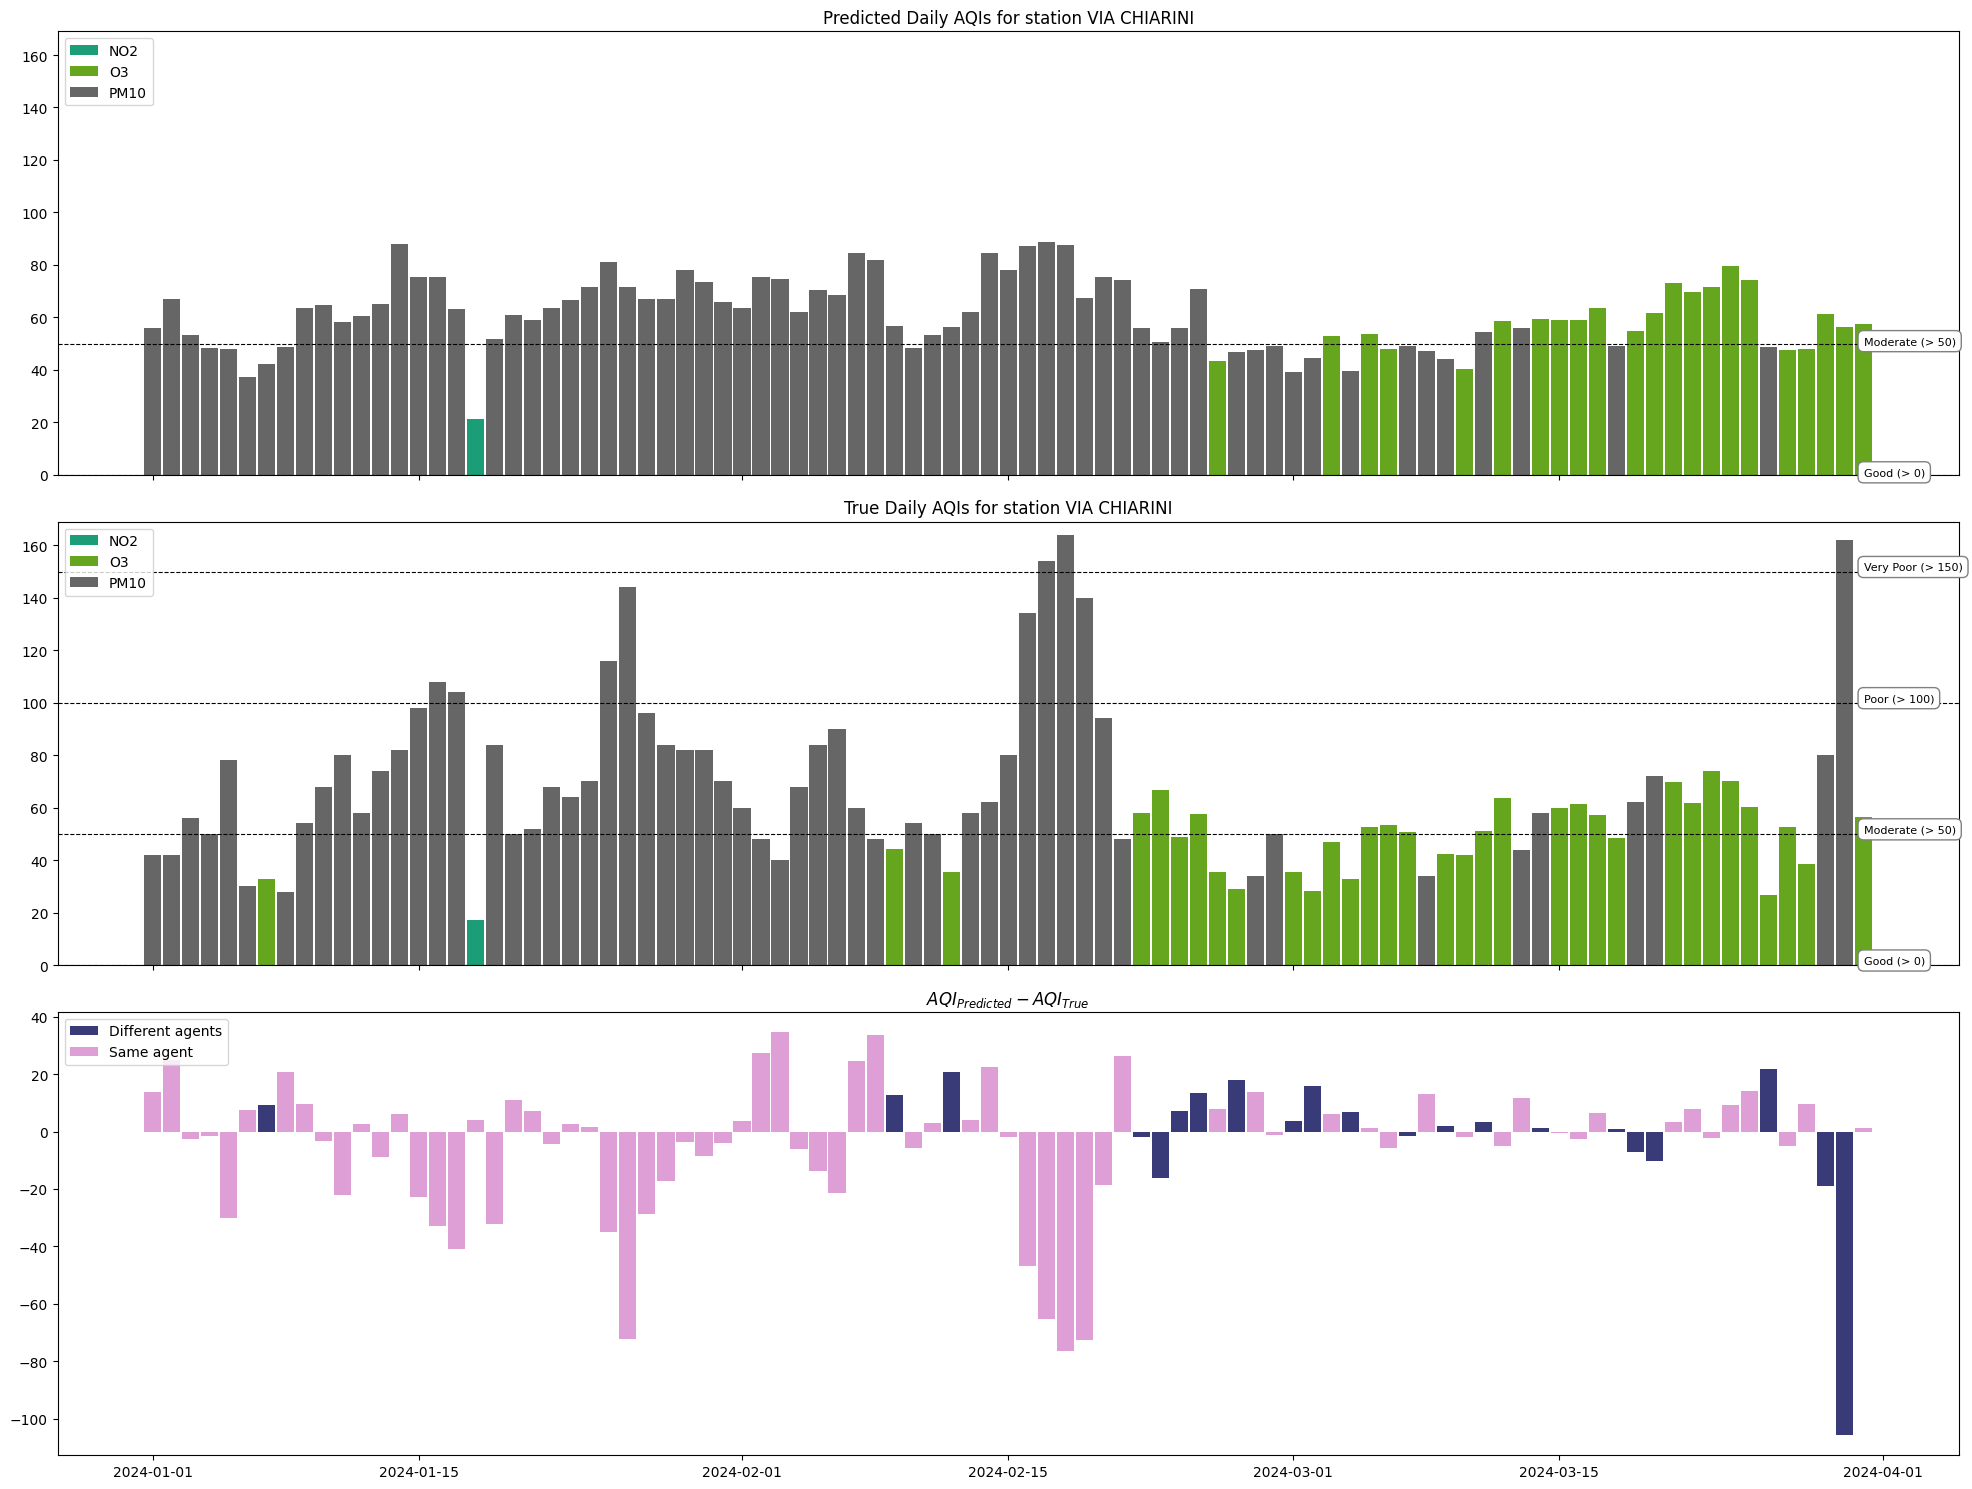

In [68]:
start=datetime(2024,1,1)
end=datetime(2024,3,31)

for station in true_AQIs_daily:
    print(f'Station {station} AQI:')
    plot_AQI(
        station_AQI=[
            pred_AQI_daily[station],
            true_AQI_daily[station],
            AQI_diff_daily[station]
        ], 
        title=[
            f'Predicted Daily AQIs for station {station}',
            f'True Daily AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ], 
        categories=categories,
        figsize=(20, 5), s=start, e=end)

Station GIARDINI MARGHERITA


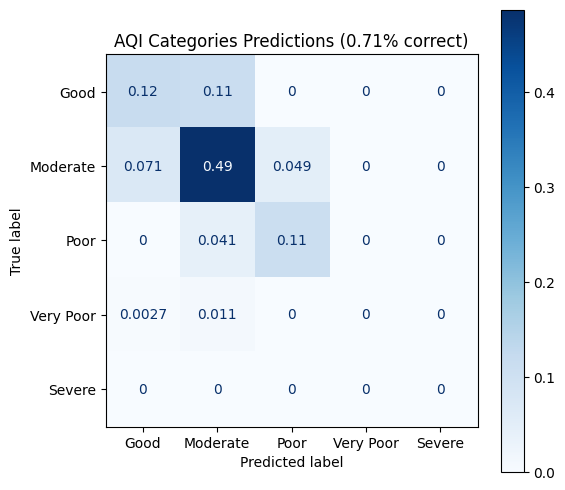

---------------------------------------------
> Absolute Mean AQI Difference: 12.62
> Positive Average AQI Difference: 10.96
> Negative Average AQI Difference: -14.57
> Percentage of Positive Differences: 54.10%
> Percentage of Negative Differences: 45.90%
> Percentage of Agent Values:
   - Same agent: 75.41
   - Different agents: 24.59
Station PORTA SAN FELICE


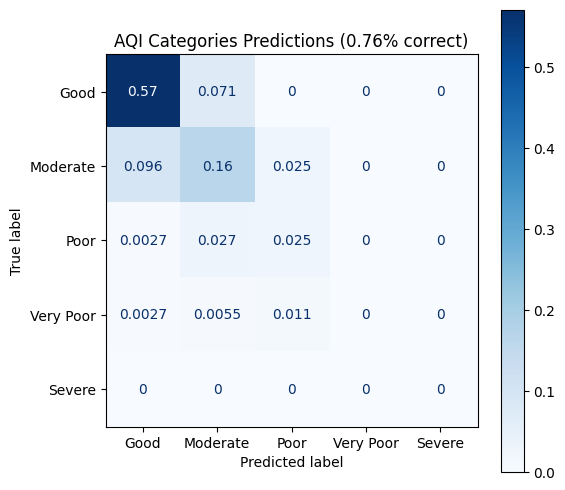

---------------------------------------------
> Absolute Mean AQI Difference: 14.47
> Positive Average AQI Difference: 11.93
> Negative Average AQI Difference: -17.74
> Percentage of Positive Differences: 56.28%
> Percentage of Negative Differences: 43.72%
> Percentage of Agent Values:
   - Same agent: 87.16
   - Different agents: 12.84
Station VIA CHIARINI


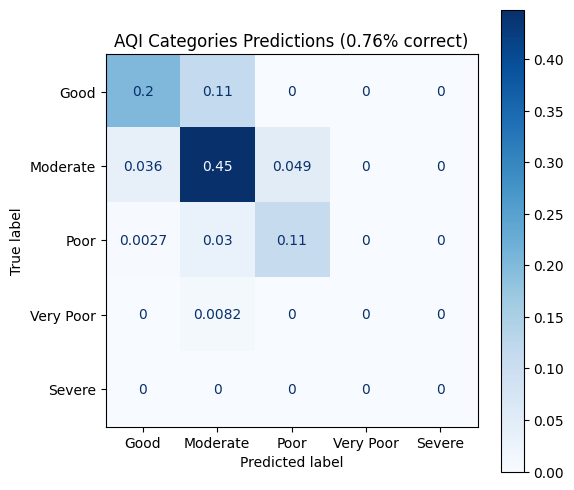

---------------------------------------------
> Absolute Mean AQI Difference: 12.43
> Positive Average AQI Difference: 11.81
> Negative Average AQI Difference: -13.77
> Percentage of Positive Differences: 68.58%
> Percentage of Negative Differences: 31.42%
> Percentage of Agent Values:
   - Same agent: 86.34
   - Different agents: 13.66


In [69]:
for station in stations:
    print('=============================================')
    print(f'Station {station}')
    print('=============================================')
    print_AQI_category_comparison(pred_AQI_daily[station],true_AQI_daily[station], categories=categories)
    print('---------------------------------------------')
    print_AQI_difference_metrics(AQI_diff_daily[station])
    print('=============================================')